In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import pytensor.tensor as pt
from sklearn.preprocessing import MaxAbsScaler
import xarray as xr

from utils import delayed_adstock
from plots import plot_posterior
from plots import plot_prior_predictive_samples


In [2]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.2.0


In [8]:
raw = pd.read_csv('../data/data.csv')
df=raw.copy()


In [10]:
spend_channels= ['spend_channel_1','spend_channel_2','spend_channel_3','spend_channel_4','spend_channel_5','spend_channel_6','spend_channel_7']
df['start_of_week'] = pd.to_datetime(df['start_of_week'],format="%d-%m-%y",dayfirst=True)
date_data= df['start_of_week']
channel_data = df[spend_channels]
target_data=df['revenue']
n_obs,n_channels= np.shape(channel_data)

In [11]:
#creating trend and seasonality
df['day'] = df.start_of_week.dt.dayofyear
n_order = 7
periods = df["day"] / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

trend = (df.index - df.index.min()) / (df.index.max() - df.index.min())
df['trend'] = trend
seasonality =  fourier_features



In [12]:
target_scaler = MaxAbsScaler()
target_scaler.fit(target_data.values.reshape(-1,1))
target_scaled = pd.Series(target_scaler.transform(target_data.values.reshape(-1,1)).flatten())

channel_scaler = MaxAbsScaler()
channel_scaler.fit(channel_data)
channel_scaled = pd.DataFrame(channel_scaler.transform(channel_data),columns=channel_data.columns)


<Axes: >

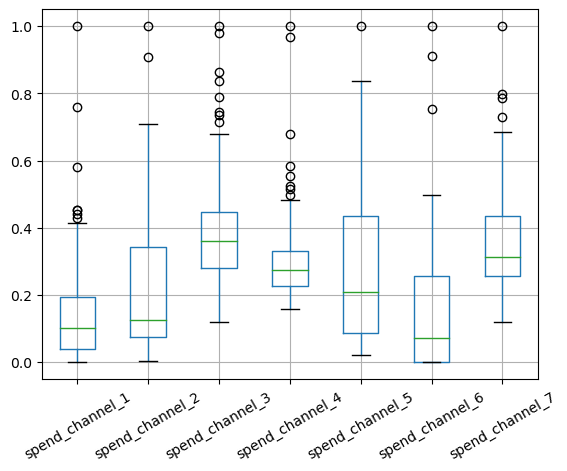

In [13]:
# outliers exist but the transformation is completed.
channel_scaled.boxplot( rot=30)

In [14]:
coords={"date": date_data,
        "channel": channel_scaled,
        "seasonality":seasonality,
        "trend":df['trend']}

In [15]:
max_lag=13

with pm.Model(coords=coords) as model:
    #data containers
    channel_data_ = pm.MutableData(
        name="channel_data",
        value=channel_scaled,
        dims=("date", "channel"),
    )
    seasonality_ = pm.MutableData(
        name="seasonality_data", value=seasonality, dims=("date", "seasonality")
    )
    trend_ = pm.MutableData(
        name="t", value=df['trend'], dims=("date")
    )
    
    target_ = pm.MutableData(name="target", value=target_scaled, dims="date")

    #priors
    intercept = pm.Normal(name="intercept", mu=0, sigma=1)
    b_trend = pm.Normal(name="b_trend", mu=0, sigma=1)
    beta_channel = pm.HalfNormal(
        name="beta_channel", sigma=1, dims="channel"
    )
    alpha = pm.Beta(name="alpha", alpha=3, beta=3, dims="channel")
    theta = pm.Uniform('delay',lower=0,upper=max_lag-1,dims='channel')
    sigma = pm.HalfNormal(name="sigma", sigma=1)
    fourier_control = pm.Laplace(
        name="gamma_control", mu=0, b=1, dims="seasonality"
    )
    # degrees of freedom of the t distribution
    nu = pm.Gamma(name="nu", alpha=15, beta=1)
    
    #model parametrization
    channel_adstock = pm.Deterministic(
        name="channel_adstock",
        var=delayed_adstock(
            x=channel_data_,
            alpha=alpha,
            theta=theta,
            l_max = max_lag-1
        ),
        dims=("date", "channel"),
    )

    channel_contributions = pm.Deterministic(
        name="channel_contributions",
        var=channel_adstock*beta_channel,
        dims=("date", "channel"),
    )
    
    mu_var =  channel_contributions.sum(axis=-1)
    
    trend = pm.Deterministic("trend", intercept + b_trend * trend_, dims="date")
    
    control_contributions = pm.Deterministic(
        name="control_contributions",
        var=seasonality_ * fourier_control,
        dims=("date", "seasonality"),
    )
    
    mu_var += control_contributions.sum(axis=-1)
    mu_var += trend
    mu = pm.Deterministic(name="mu", var=mu_var, dims="date")

    pm.StudentT(
        name="likelihood",
        nu=nu,
        mu=mu,
        sigma=sigma,
        observed=target_,
        dims="date",
    )
    model_prior_predictive = pm.sample_prior_predictive()

Sampling: [alpha, b_trend, beta_channel, delay, gamma_control, intercept, likelihood, nu, sigma]


In [16]:
model

            intercept ~ N(0, 1)
              b_trend ~ N(0, 1)
         beta_channel ~ N**+(0, 1)
                alpha ~ Beta(3, 3)
                delay ~ U(0, 12)
                sigma ~ N**+(0, 1)
        gamma_control ~ Laplace(0, 1)
                   nu ~ Gamma(15, f())
      channel_adstock ~ Deterministic(f(alpha, delay))
channel_contributions ~ Deterministic(f(beta_channel, alpha, delay))
                trend ~ Deterministic(f(intercept, b_trend))
control_contributions ~ Deterministic(f(gamma_control))
                   mu ~ Deterministic(f(intercept, b_trend, gamma_control, beta_channel, alpha, delay))
           likelihood ~ StudentT(nu, mu, sigma)

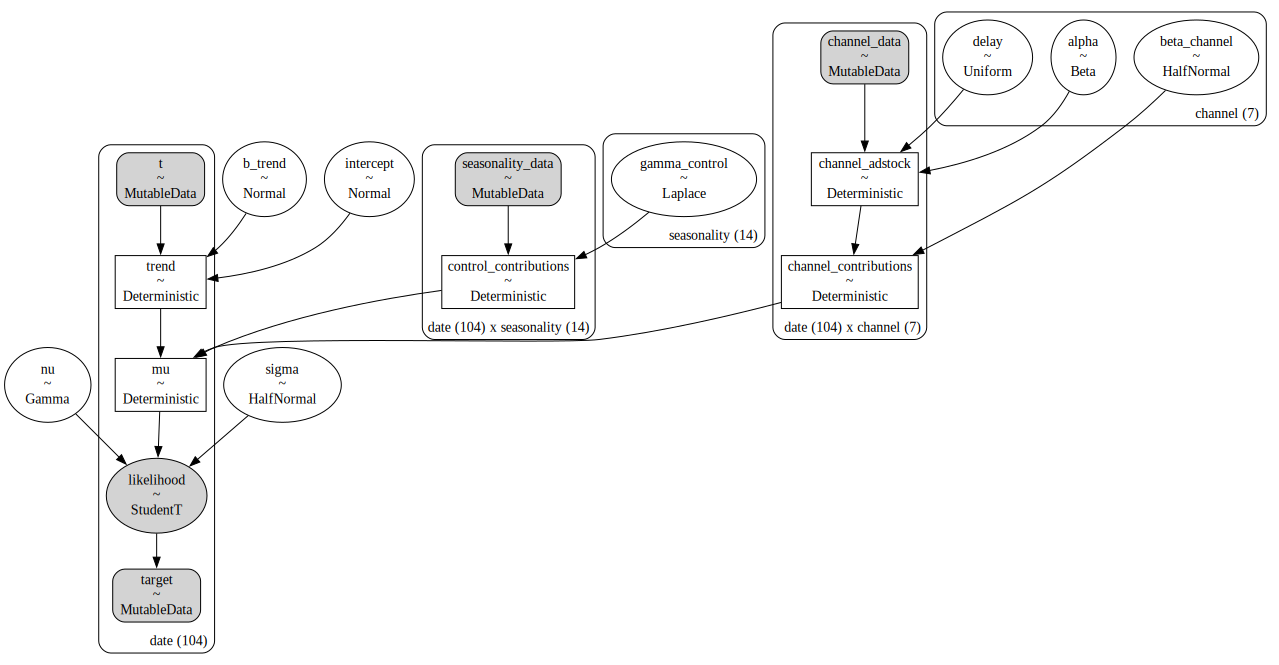

In [17]:
pm.model_to_graphviz(model=model)

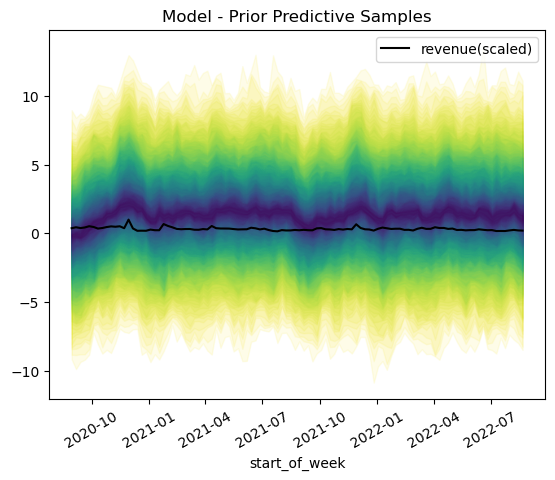

In [18]:
# useful way to color the distribution
plot_settings={
'palette' :"viridis_r",
'cmap' :plt.get_cmap("viridis_r"),
'percs' :np.linspace(51, 99, 100),
'colors' :(np.linspace(51, 99, 100) - np.min(np.linspace(51, 99, 100))) / (np.max(np.linspace(51, 99, 100)) - np.min(np.linspace(51, 99, 100)))}
plot_prior_predictive_samples(model_prior_predictive,target_scaled,date_data,plot_settings)


In [19]:
with model:
    model_trace = pm.sample(
        nuts_sampler="numpyro",
        draws=8_000,
        chains=4,
        idata_kwargs={"log_likelihood": True},
    )
    model_posterior_predictive = pm.sample_posterior_predictive(
        trace=model_trace
    )

/home/shamecube/miniconda3/envs/bayes/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)
/home/shamecube/miniconda3/envs/bayes/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Compiling...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compilation time =  0:00:06.449740
Sampling...


Compiling.. :   0%|                                                                                                                                                                      | 0/9000 [00:00<?, ?it/s]

  0%|                                                                                                                                                                                    | 0/9000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                                                                                                      | 0/9000 [00:00<?, ?it/s]


  0%|                                                                                                                                                                                    | 0/9000 [00:00<?, ?it/s]


Running chain 0:   0%|                                                                                                                                

Running chain 0:  55%|███████████████████████████████████████████████████████████████████████████████████                                                                    | 4950/9000 [00:37<00:23, 173.14it/s]

Running chain 1:  55%|███████████████████████████████████████████████████████████████████████████████████                                                                    | 4950/9000 [00:37<00:23, 169.47it/s]


Running chain 3:  45%|███████████████████████████████████████████████████████████████████▉                                                                                   | 4050/9000 [00:38<00:34, 145.09it/s]

Running chain 1:  60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 5400/9000 [00:40<00:20, 173.82it/s]


Running chain 3:  50%|███████████████████████████████████████████████████████████████████████████▌                                                    

Sampling time =  0:01:07.734682
Transforming variables...
Transformation time =  0:00:05.027761
Computing Log Likelihood...
Log Likelihood time =  0:00:04.801736


Sampling: [likelihood]


In [20]:
az.summary(
    data=model_trace,
    var_names=['alpha','delay','intercept','b_trend','beta_channel','sigma'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
alpha[spend_channel_1]         0.478  0.193   0.129    0.825      0.001   
alpha[spend_channel_2]         0.598  0.189   0.255    0.928      0.001   
alpha[spend_channel_3]         0.446  0.172   0.136    0.769      0.001   
alpha[spend_channel_4]         0.511  0.190   0.163    0.852      0.001   
alpha[spend_channel_5]         0.497  0.186   0.157    0.831      0.001   
alpha[spend_channel_6]         0.552  0.173   0.217    0.842      0.001   
alpha[spend_channel_7]         0.498  0.181   0.169    0.830      0.001   
delay[spend_channel_1]         6.460  2.597   0.897   10.601      0.034   
delay[spend_channel_2]         3.679  2.300   0.001    8.449      0.031   
delay[spend_channel_3]         0.380  0.876   0.000    0.649      0.028   
delay[spend_channel_4]         4.829  3.251   0.000   10.236      0.030   
delay[spend_channel_5]         4.573  3.726   0.001   11.068      0.033   
delay[spend_channel_6]         1.346  0.749   0.061    2.196      0.009   
delay[spend_channel_7]         3.147  1.062   0.077    4.165      0.026   
intercept                      0.011  0.075  -0.129    0.158      0.001   
b_trend                       -0.187  0.080  -0.333   -0.033      0.001   
beta_channel[spend_channel_1]  0.116  0.087   0.000    0.272      0.001   
beta_channel[spend_channel_2]  0.226  0.104   0.028    0.414      0.001   
beta_channel[spend_channel_3]  0.374  0.122   0.140    0.615      0.002   
beta_channel[spend_channel_4]  0.088  0.074   0.000    0.222      0.001   
beta_channel[spend_channel_5]  0.040  0.045   0.000    0.123      0.000   
beta_channel[spend_channel_6]  0.303  0.096   0.118    0.484      0.002   
beta_channel[spend_channel_7]  0.323  0.112   0.100    0.529      0.001   
sigma                          0.057  0.007   0.043    0.071      0.000   

                               mcse_sd  ess_bulk  ess_tail  r_hat  
alpha[spend_channel_1]           0.001   22120.0   20944.0    1.0  
alpha[spend_channel_2]           0.001   21638.0   20886.0    1.0  
alpha[spend_channel_3]           0.001   17248.0   15235.0    1.0  
alpha[spend_channel_4]           0.001   30005.0   21912.0    1.0  
alpha[spend_channel_5]           0.001   28407.0   22287.0    1.0  
alpha[spend_channel_6]           0.001   20858.0   21536.0    1.0  
alpha[spend_channel_7]           0.001   19467.0   18072.0    1.0  
delay[spend_channel_1]           0.024    8132.0   13672.0    1.0  
delay[spend_channel_2]           0.022    6059.0    9901.0    1.0  
delay[spend_channel_3]           0.020    3667.0    1115.0    1.0  
delay[spend_channel_4]           0.022   11336.0   16234.0    1.0  
delay[spend_channel_5]           0.023   14578.0   19996.0    1.0  
delay[spend_channel_6]           0.007   10696.0    7820.0    1.0  
delay[spend_channel_7]           0.018    2836.0    1167.0    1.0  
intercept                        0.001    2894.0    2720.0    1.0  
b_trend                          0.001    9567.0   11681.0    1.0  
beta_channel[spend_channel_1]    0.001    7674.0   14531.0    1.0  
beta_channel[spend_channel_2]    0.001    8859.0   10703.0    1.0  
beta_channel[spend_channel_3]    0.002    2812.0    1804.0    1.0  
beta_channel[spend_channel_4]    0.000   11849.0   13557.0    1.0  
beta_channel[spend_channel_5]    0.000   12056.0   14711.0    1.0  
beta_channel[spend_channel_6]    0.001    3962.0    3177.0    1.0  
beta_channel[spend_channel_7]    0.001    8238.0    7599.0    1.0  
sigma                            0.000   11686.0   19121.0    1.0

/home/shamecube/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (22), generating only 20 plots
  warnings.warn(


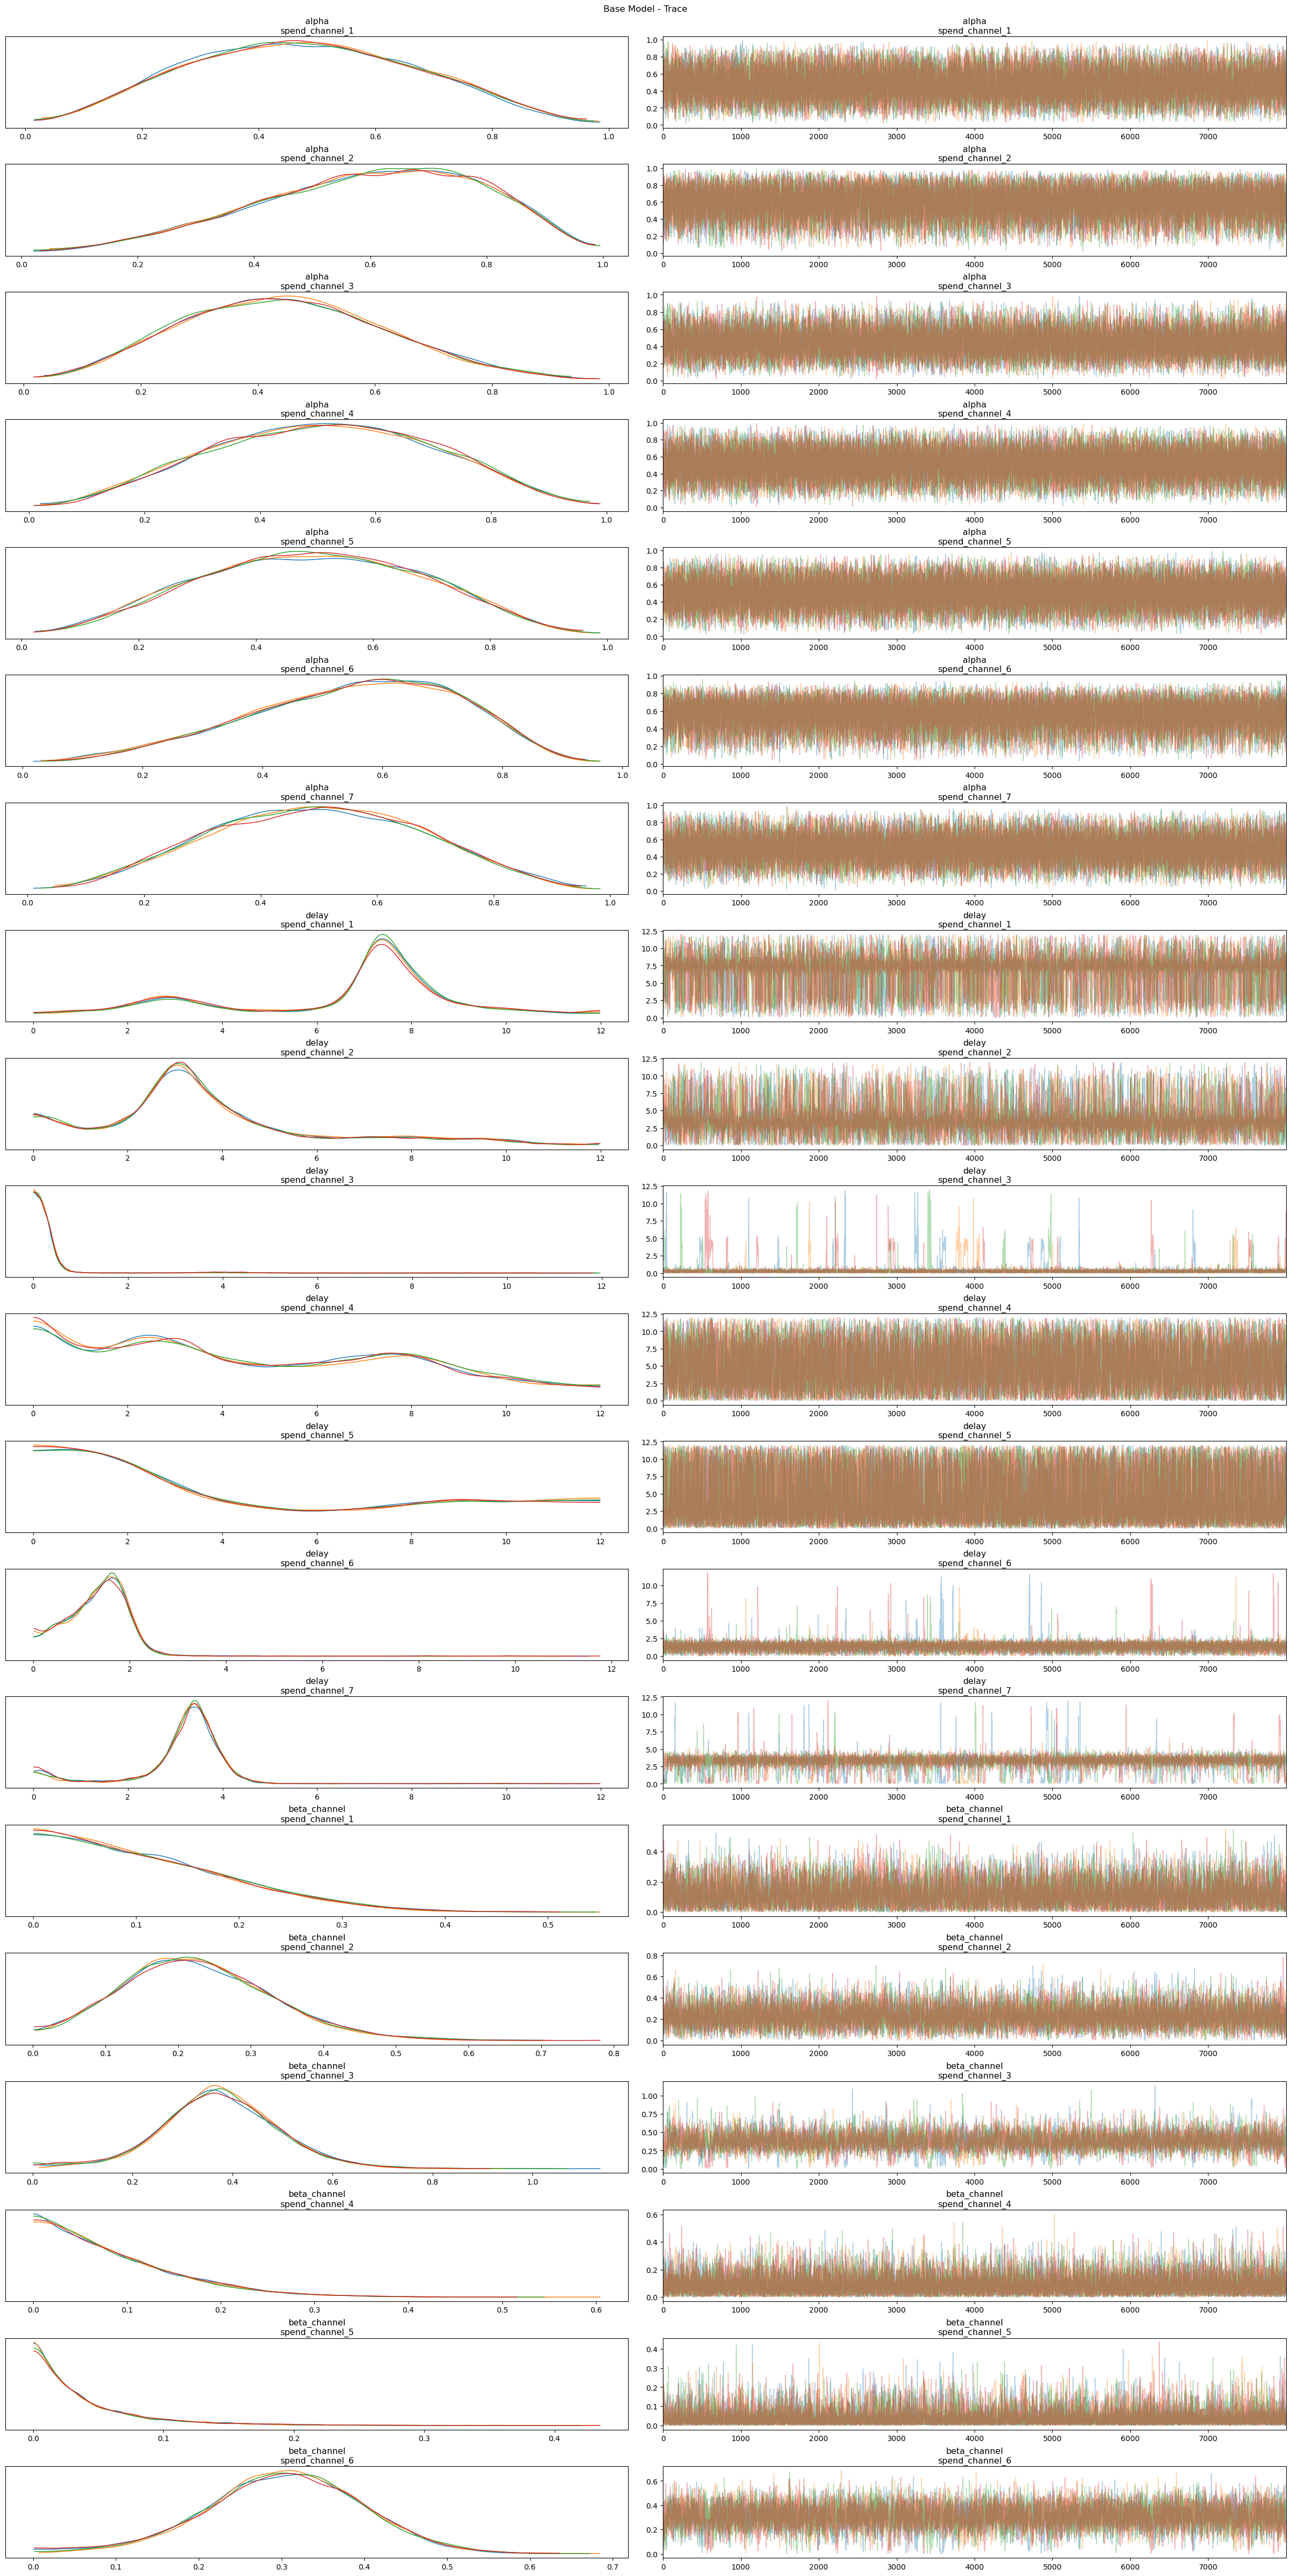

In [21]:
axes = az.plot_trace(
    data=model_trace,
#     var_names=['alpha','delay','intercept','b_trend','beta_channel','nu','gamma_control'],
    var_names=['alpha','delay','beta_channel','sigma'],
    compact=False,
    combined=False,
    backend_kwargs={
        "figsize": (24, 48),
        "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()
fig.suptitle("Base Model - Trace")
plt.show()
# here we see on the right side distribtuion on each chain seperatly . on left we see the 
# convergence on each chain.

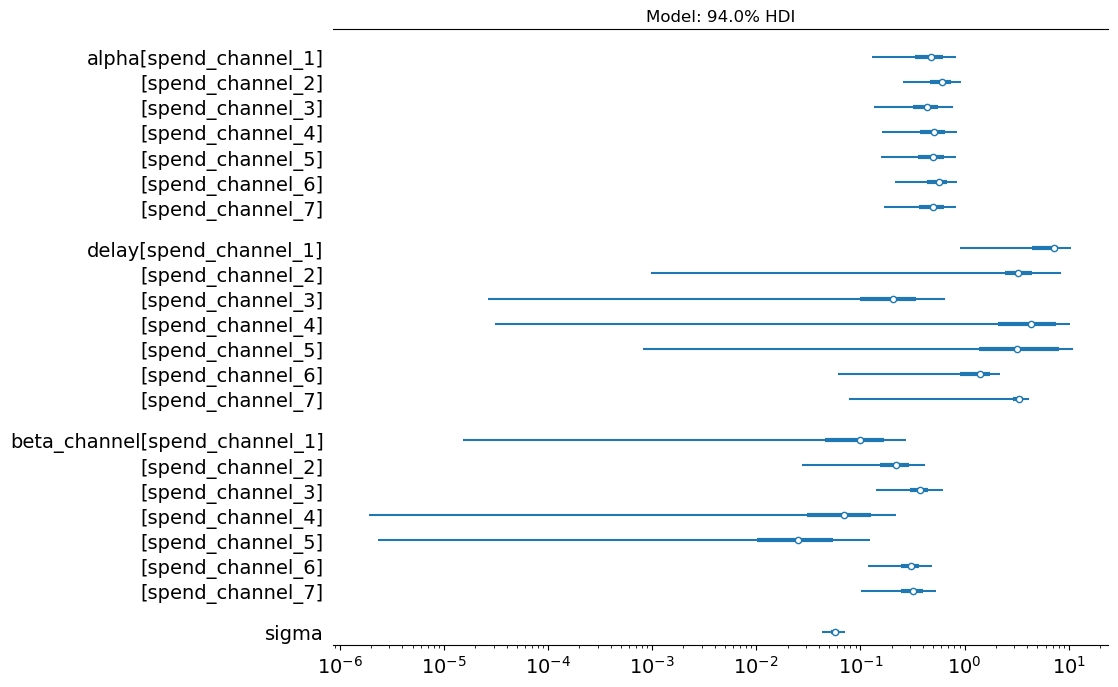

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))
az.plot_forest(
    data=model_trace,
    var_names=['alpha','delay','beta_channel','sigma'],
    combined=True,
    ax=ax
)
ax.set(
    title="Model: 94.0% HDI",
    xscale="log"
)
plt.show()

In [ ]:
## posterior prediction

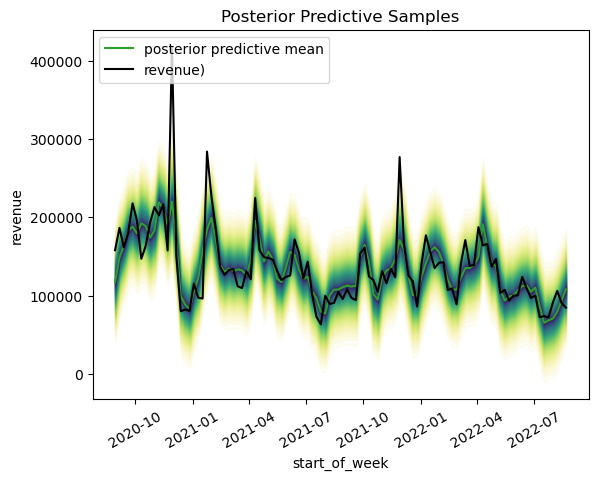

In [23]:
plot_posterior(model_posterior_predictive,date_data,target_data,target_scaler,plot_settings)


In [ ]:
#The HDI can be used in the context of
#uncertainty characterisation of posterior distributions as Credible Interval (CI).
model_hdi = az.hdi(ary=model_trace)

fig, ax = plt.subplots(figsize=(18, 12))

for i in range(n_channels):
    ax.fill_between(
        x=date_data,
        y1=model_hdi['channel_contributions'][:, i,0],
        y2=model_hdi['channel_contributions'][:, i,1],
        color=f"C{i}",
        alpha=0.3,
        label=f"$94\%$ HDI (channel {i})",
    )
    sns.lineplot(
        x=date_data,
        y=model_trace.posterior['channel_contributions'].stack(sample=("chain", "draw")).mean(axis=2)[:,i]
    )
sns.lineplot(x=date_data, y=target_scaled, color="black", alpha=1.0, label="target (scaled)", ax=ax)
plt.show()

In [ ]:
# compute HDI for all the control parameters
fig, ax = plt.subplots()

for i in range(n_channels):
    ax.fill_between(
        x=date_data,
        y1=model_hdi['control_contributions'][:, i,0],
        y2=model_hdi['control_contributions'][:, i,1],
        color=f"C{i}",
        alpha=0.2,
        label=f"$94\%$ HDI ('control_contributions'{i})",
    )
    sns.lineplot(
        x=date_data,
        y=model_trace.posterior['control_contributions'].stack(sample=("chain", "draw")).mean(axis=2)[:,i]
    )

ax.fill_between(
    x=date_data,
    y1=model_hdi['trend'][:,0],
    y2=model_hdi['trend'][:,1],
    color=f"C{i}",
    alpha=0.2,
    label=f"$94\%$ HDI ({'trend'})",
)
sns.lineplot(
    x=date_data,
    y=model_trace.posterior['trend'].stack(sample=("chain", "draw")).mean(axis=1)
)
sns.lineplot(x=date_data, y=target_scaled, color="black", alpha=0.8, label="target (scaled)", ax=ax)
plt.xticks(rotation=30)
plt.show()

In [ ]:
#channel contribtuion figures

channel_contributions_posterior_samples = xr.apply_ufunc(
    lambda x: channel_scaler.inverse_transform(X=x),
    model_trace.posterior["channel_contributions"],
    input_core_dims=[["date","channel"]],
    output_core_dims=[["date","channel"]],
    vectorize=True,
)


channel_effect_hdi = az.hdi(ary=channel_contributions_posterior_samples)["channel_contributions"]

for i in range(n_channels):

    fig, ax = plt.subplots()
    ax.fill_between(
        x=date_data,
        y1=channel_effect_hdi[:,i ,0],
        y2=channel_effect_hdi[:,i ,1],
        color="C0",
        alpha=0.5,
        label=f"$94\%$ HDI (channel {i+1})",
    )
    ax.tick_params(labelrotation=30)
    sns.lineplot(
        x=date_data,
        y=channel_contributions_posterior_samples.stack(sample=("chain", "draw")).mean(axis=2)[:,i],
        linestyle="--",
    )
ax.legend(loc="upper right")
plt.show()

In [ ]:
# 2nd model with normal likelihood
max_lag=13

with pm.Model(coords=coords) as model_normal:
    #data containers
    channel_data_ = pm.MutableData(
        name="channel_data",
        value=channel_scaled,
        dims=("date", "channel"),
    )
    seasonality_ = pm.MutableData(
        name="seasonality_data", value=seasonality, dims=("date", "seasonality")
    )
    trend_ = pm.MutableData(
        name="t", value=df['trend'], dims=("date")
    )
    
    target_ = pm.MutableData(name="target", value=target_scaled, dims="date")

    #-priors
    intercept = pm.Normal(name="intercept", mu=0, sigma=1)
    b_trend = pm.Normal(name="b_trend", mu=0, sigma=1)
    beta_channel = pm.HalfNormal(
        name="beta_channel", sigma=1, dims="channel"
    )
    alpha = pm.Beta(name="alpha", alpha=3, beta=3, dims="channel")
    theta = pm.Uniform('delay',lower=0,upper=max_lag,dims='channel')
    sigma = pm.HalfNormal(name="sigma", sigma=1)
    fourier_control = pm.Laplace(
        name="gamma_control", mu=0, b=1, dims="seasonality"
    )
    #model parametrization
    channel_adstock = pm.Deterministic(
        name="channel_adstock",
        var=delayed_adstock(
            x=channel_data_,
            alpha=alpha,
            theta=theta,
            l_max = max_lag-1
        ),
        dims=("date", "channel"),
    )

    channel_contributions = pm.Deterministic(
        name="channel_contributions",
        var=channel_adstock*beta_channel,
        dims=("date", "channel"),
    )
    
    mu_var =  channel_contributions.sum(axis=-1)
    
    trend = pm.Deterministic("trend", intercept + b_trend * trend_, dims="date")
    
    control_contributions = pm.Deterministic(
        name="control_contributions",
        var=seasonality_ * fourier_control,
        dims=("date", "seasonality"),
    )
    
    mu_var += control_contributions.sum(axis=-1)
    mu_var += trend
    mu = pm.Deterministic(name="mu", var=mu_var, dims="date")

    pm.Normal(
                name="likelihood",
                mu=mu,
                sigma=sigma,
                observed=target_,
                dims="date",
            )
    model_prior_predictive_normal = pm.sample_prior_predictive()

In [ ]:
model_normal

In [ ]:
with model_normal:
    model_trace_normal = pm.sample(
        nuts_sampler="numpyro",
        draws=8_000,
        chains=4,
        idata_kwargs={"log_likelihood": True},
    )
    model_posterior_predictive_normal = pm.sample_posterior_predictive(
        trace=model_trace_normal
    )

In [ ]:
dataset_dict = {
    "model": model_trace,
    "model_normal": model_trace_normal,
}
df_comp = az.compare(compare_dict=dataset_dict, ic="loo", method="stacking", scale="log")
df_comp

In [ ]:
az.plot_compare(df_comp, insample_dev=False)
plt.show()

In [ ]:
axes = az.plot_forest(
    data=[model_trace, model_trace_normal],
    model_names=["model", "model_normal"],
    var_names=['alpha','delay','sigma'],
    combined=True,
    figsize=(10, 7),
)
plt.show()

In [ ]:
axes = az.plot_forest(
    data=[model_trace, model_trace_normal],
    model_names=["model", "model_normal"],
    var_names=['beta_channel'],
    combined=True,
    figsize=(10, 7),
)
plt.show()